In [3]:
import sqlite3
import pandas as pd
from ggplot import *
from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import statsmodels.api as sm

C:\Users\David\Anaconda2\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\David\Anaconda2\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\David\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# Extract production data
conn = sqlite3.connect('pv_production_CA.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())
gen_data = pd.read_sql_query("SELECT * from la_gen", conn)
conn.close()

[(u'la_gen',), (u'redd_gen',), (u'fres_gen',)]


In [5]:
gen_data['date_time'] = pd.to_datetime(gen_data['date_time'], format = '%Y-%m-%d %H:%M:%S')
gen_data['generation'] = gen_data['generation'].astype('float')
gen_june = gen_data[(gen_data['date_time'] >= datetime.strptime('2017-06-01 00:00:00','%Y-%m-%d %H:%M:%S')) & (gen_data['date_time'] < datetime.strptime('2017-07-01 00:00:00','%Y-%m-%d %H:%M:%S'))]

In [6]:
### Simulates solar output and load given random weather events

In [7]:
gen_june.head(n=24)

,index,date_time,generation,hour
3624,3624,2017-06-01 00:00:00,0.000,00
3625,3625,2017-06-01 01:00:00,0.000,01
3626,3626,2017-06-01 02:00:00,0.000,02
3627,3627,2017-06-01 03:00:00,0.000,03
3628,3628,2017-06-01 04:00:00,0.000,04
3629,3629,2017-06-01 05:00:00,150.114,05
3630,3630,2017-06-01 06:00:00,500.639,06
3631,3631,2017-06-01 07:00:00,969.551,07
3632,3632,2017-06-01 08:00:00,1572.205,08
3633,3633,2017-06-01 09:00:00,2268.267,09


In [8]:
# Called in solar_sim function
def wtr_sim(load,wtr):
    return load - (.1*load*wtr)

In [21]:
## Input hourly data using solar production data from "API_query_function"
def solar_sim(data):
# Randomly create variation in each hours' load by creating a vector of random numbers mean = 0 for each hour
# To add variability, or to create a drift, 
    mu, sigma = 0, 1 # mean and standard deviation
    wiggle = np.random.normal(mu, sigma, 24*30)
# load_lst indicates the expected hourly load profile for a representative day
    load_lst = []
    load_lst = [10,10,9,8,10,14,17,18,20,21,25,28,31,32,37,38,42,43,44,46,40,35,30,20]
# Creates hours of the day that correspond to each load hour
    load_base =  {'hour': [x for x in range(24)],
                'base': load_lst}
    load_base = pd.DataFrame(load_base)
# Creates hourly loads for each hour of the month, adjusted by a random variable mean=0 and sd=1,
# then multiplied by .1 times base load. This means, for example, that an event that is 1 sd is 10%
# above the base load for that hour.
# Note that this performs the operation for a 30-day month
    load_month = [((wiggle[(0+i2) + (23*i1)]*(.1*j)) + j) for i1,i in enumerate(range(30)) for i2,j in enumerate(load_base.base)]
# Convert load_month to a dataframe    
    load_act = {'load_hr': load_month}
    load_act = pd.DataFrame(load_act)
# Create two lists with days and hours.
    hours = [j for i in range(30) for j in range(24)]
    day = []
    for i in range(30):
        for j in range(24):
            day.append(i+1)
    load_act['day'] = day
    load_act['hour'] = hours
## Create index
    ind = []
    for i in range(720):
        ind.append(i)
    load_act['index'] = ind
    generation = data['generation']/1000
# Creating weather shocks: # Parameterize weather shock as a certain distribution of shock over each city
    a = np.random.exponential(scale = .4, size = 1000)
    ### Conduct simulations
## Simulate representative generator then run a total 1000 simulations for each city
# Create a daily weather variable that is 1 or 0 to indicate whether random weather events occur (probabilities vary)
# weather is assumed to be statewide
    weather_dum = []
    for i in range(30):
        weather = np.random.uniform(0,1)
        if weather < .25:
            w_dummy = 1
        else:
            w_dummy = 0
        weather_dum.extend([w_dummy]*24)
        
    for i in range(1000):
        if i == 0:
            sim = generation.apply(lambda x: max(x-np.random.exponential(scale = .4),0) if x !=0 else x)
            rep_sim = sim
            continue
        sim = sim + generation.apply(lambda x: max(x-np.random.exponential(scale = .4),0) if x !=0 else x)
# Build simulation dataframe
    month_sim = {'rep_sim': rep_sim,'sim': sim,'weather': weather_dum}
    month_sim = pd.DataFrame(month_sim)
# Create an index to merge with load_act
    month_sim['index'] = ind
    load_gen = load_act.merge(month_sim,on='index')
# Introduces load shocks per the wtr_sim function   
    load_gen['load_hr'] = load_gen.apply(lambda x: wtr_sim(x['load_hr'],x['weather']),axis=1)
    load_gen['date_time'] = data['date_time'].values
    return load_gen
    

In [22]:
june_sim = solar_sim(gen_june)

In [11]:
## Analysis of simulations
# Runs analysis using a sparse model, a model including solar output, and a model with dummy variables

In [17]:
june_sim.head(n=24)

,load_hr,day,hour,index,rep_sim,sim,weather,date_time
0,7.846376,1,0,0,0.000000,0.000000,1,2017-06-01 00:00:00
1,9.299131,1,1,1,0.000000,0.000000,1,2017-06-01 01:00:00
2,7.459470,1,2,2,0.000000,0.000000,1,2017-06-01 02:00:00
3,6.455412,1,3,3,0.000000,0.000000,1,2017-06-01 03:00:00
4,7.829892,1,4,4,0.000000,0.000000,1,2017-06-01 04:00:00
5,12.745204,1,5,5,0.000000,80.357994,1,2017-06-01 05:00:00
6,14.991328,1,6,6,0.000000,643.294812,1,2017-06-01 06:00:00
7,17.896529,1,7,7,0.960988,1813.095115,1,2017-06-01 07:00:00
8,18.986108,1,8,8,0.137506,3541.084082,1,2017-06-01 08:00:00
9,18.883085,1,9,9,1.910650,5608.352714,1,2017-06-01 09:00:00


In [19]:
# Run dataframe through function to get analysis
def solar_model(raw_data):
    dummies = pd.get_dummies(raw_data.hour)
    data = raw_data.join(dummies,how='inner')
    data = sm.add_constant(data)
#   convert load_hr to kwh and subtract "sim" variables from load_hr to get net load
    data.load_hr = (data.load_hr*1000) - data.sim
# Create lagged variables
    data['load_lag1'] = data['load_hr'].shift()
    data['load_lag24'] = data['load_hr'].shift(24)
# Drop N/A values from lagging
    prediction_plot = data[['load_hr','rep_sim','load_lag1','load_lag24','weather','day','hour','index','const',7,8,9,10,11,12,13,14,15,16]]
    prediction_plot = prediction_plot.dropna(axis=0,how='any')
    
# Generate models
    sparse_model = sm.OLS(endog=prediction_plot['load_hr'], exog=prediction_plot[['const','weather','load_lag1','load_lag24']], missing='drop').fit()
    extended_model = sm.OLS(endog=prediction_plot['load_hr'], exog=prediction_plot[['const','weather','load_lag1','load_lag24','rep_sim', \
                    ]], missing='drop').fit()
    dummy_model = sm.OLS(endog=prediction_plot['load_hr'], exog=prediction_plot[['const','weather','load_lag1','load_lag24','rep_sim', \
                    7,8,9,10,11,12,13,14,15,16]], missing='drop').fit()
# Graph results
    plt.close()
    plt.scatter(prediction_plot['load_hr'],sparse_model.predict(),label='predicted')
    plt.plot([0,50000],[0,50000],color='r')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('Sparse model: actual v. predicted')
    plt.show()
    plt.close()
    
    plt.scatter(prediction_plot['load_hr'],extended_model.predict(),label='predicted')
    plt.plot([0,50000],[0,50000],color='r')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('Extended model: actual v. predicted')
    plt.show()
    plt.close()
    
    plt.scatter(prediction_plot['load_hr'],dummy_model.predict(),label='predicted')
    plt.plot([0,50000],[0,50000],color='r')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('Dummy model: actual v. predicted')
    plt.show()
    plt.close()
    
    print sparse_model.summary()
    print extended_model.summary()
    print dummy_model.summary()
    return ''
    

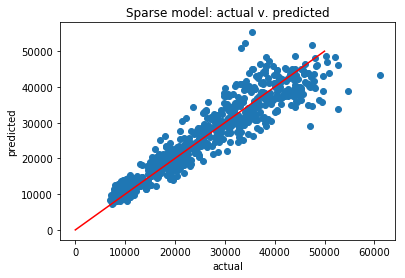

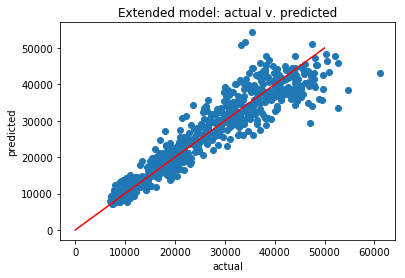

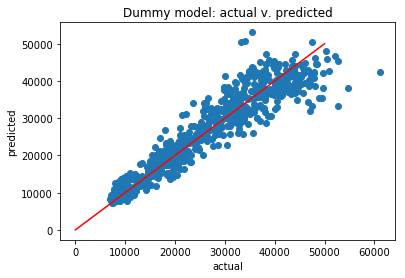

                            OLS Regression Results                            
Dep. Variable:                load_hr   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1845.
Date:                Sun, 25 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:42:54   Log-Likelihood:                -6778.3
No. Observations:                 696   AIC:                         1.356e+04
Df Residuals:                     692   BIC:                         1.358e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1055.5713    371.951      2.838      0.0

''

In [23]:
solar_model(june_sim)